## Benefits and restrictions of stareg

test staregs capability for constraint regression on the following examples:

1. $f(x) = 2.1*\exp(-\frac{(x - 0.2)^2}{0.01})$
2. $f(x) = 2.3*x - 3*x^3$

Important points to consider are the following:

- Data distribution: bulk vs. well behaving
- Signal to noise ratio

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from stareg.star_model import StarModel
from stareg.utils import check_constraint_full_model
from plotly.subplots import make_subplots
np.random.seed(42)

In [2]:
samples = 200
x = np.random.random(samples).reshape((-1,1))
x.sort(axis=0)
noise = np.random.random(samples).reshape((-1,1))

#y_true = -2.1*np.exp(-(x - 0.2)**3 / 0.1) 
y_true = 2.1*np.exp(-(x - 0.2)**2 / 0.1) 
y = y_true + 0.2*noise

# Data Preprocessing
xmin, xmax = x.min(), x.max()
ymean, ystd = y.mean(), y.std()

#x_transformed = (x - xmin) / (xmax - xmin)
#y_transformed = (y - ymean) / ystd
x_transformed = x
y_transformed = y
# Train Test Split
df = pd.DataFrame(data={"x":x_transformed.ravel(), "y":y_transformed.ravel()})
df_train, df_test = train_test_split(df, test_size=0.33, random_state=42)
df_train, df_test = df_train.sort_index(), df_test.sort_index()
X_train, y_train = df_train["x"].values.reshape((-1,1)), df_train["y"].values
X_test, y_test = x_transformed[df_test.index], y_transformed[df_test.index]

In [5]:
# Model creation
description = ( ("s(1)", "peak", 30, (0, 0), "equidistant"), )
M = StarModel(description=description)
M.fit(X=X_train, y=y_train, plot_=False)
print("MSE = ", M.mse)
print("Metric = ", M.eval_metric(X=X_test, y=y_test.ravel()))
#Mbest = M.calc_GCV(X=X_train, y=y_train, n_grid=5)

MSE =  0.0030303
Metric =  0.14611


In [7]:
# Model creation
description = ( ("s(1)", "peak", 30, (0, 5000), "equidistant"), )
M = StarModel(description=description)
M.fit(X=X_train, y=y_train, plot_=False)
print("MSE = ", M.mse)
print("Metric = ", M.eval_metric(X=X_test, y=y_test.ravel()))
#Mbest = M.calc_GCV(X=X_train, y=y_train, n_grid=5)

MSE =  0.0031335
Metric =  0.14632


In [8]:
# Model creation
description = ( ("s(1)", "peak", 30, (1, 0), "equidistant"), )
M = StarModel(description=description)
M.fit(X=X_train, y=y_train, plot_=False)
print("MSE = ", M.mse)
print("Metric = ", M.eval_metric(X=X_test, y=y_test.ravel()))
#Mbest = M.calc_GCV(X=X_train, y=y_train, n_grid=5)

MSE =  0.0032728
Metric =  0.14583


In [9]:
# Model creation
description = ( ("s(1)", "peak", 30, (1, 100), "equidistant"), )
M = StarModel(description=description)
M.fit(X=X_train, y=y_train, plot_=False)
print("MSE = ", M.mse)
print("Metric = ", M.eval_metric(X=X_test, y=y_test.ravel()))
#Mbest = M.calc_GCV(X=X_train, y=y_train, n_grid=5)

MSE =  0.0034798
Metric =  0.10932


In [10]:
# Model creation
description = ( ("s(1)", "peak", 30, (1, 1000), "equidistant"), )
M = StarModel(description=description)
M.fit(X=X_train, y=y_train, plot_=False)
print("MSE = ", M.mse)
print("Metric = ", M.eval_metric(X=X_test, y=y_test.ravel()))
#Mbest = M.calc_GCV(X=X_train, y=y_train, n_grid=5)

MSE =  0.0034989
Metric =  0.10938


In [12]:
from stareg.bspline import Bspline

BS = Bspline()

xx = np.linspace(0,1,1000)
BS.bspline_basis(x_data=xx, k=M.smooths["s(1)"].n_param)

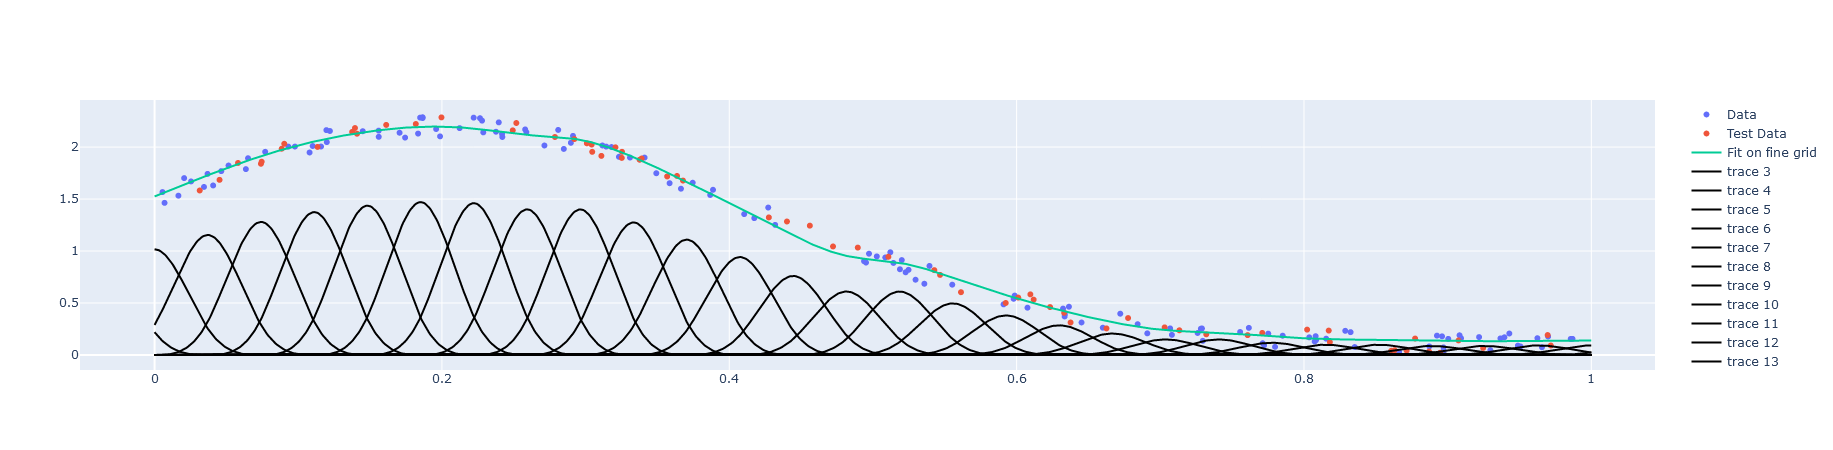

In [13]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_train.ravel(), y=y_train.ravel(), name="Data", mode="markers"))
fig.add_trace(go.Scatter(x=X_test.ravel(), y=y_test.ravel(), name="Test Data", mode="markers"))
fig.add_trace(go.Scatter(x=xx, y=BS.basis @ M.coef_, name="Fit on fine grid"))
for i in range(BS.basis.shape[1]):
    #fig.add_trace(go.Scatter(x=xx, y=BS.basis[:,i]))
    fig.add_trace(go.Scatter(x=xx, y=BS.basis[:,i] * M.coef_[i], line=dict(color="black")))
fig.show()
